In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import feather
from evaluator import Evaluator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

In [2]:
training_ratings = feather.read_dataframe('./feather/training_ratings')
testing_ratings = feather.read_dataframe('./feather/testing_ratings')
book_profiles = feather.read_dataframe('./feather/book_profiles').set_index('book_id')
novelty_scores = feather.read_dataframe('./feather/novelty_scores').set_index('book_id')
books = feather.read_dataframe('./feather/books').set_index('book_id')

In [3]:
book_sim = pd.DataFrame(
    data = cosine_similarity(book_profiles, book_profiles),
    index = book_profiles.index,
    columns = book_profiles.index
)

book_sim.head()

book_id,27,21,2,18,24,3275,3753,54,337,374,...,5111,5296,8713,7443,6428,7523,4594,9569,9580,8892
book_id,,,,,,,,,,,,,,,,,,,,,
27,1.000000,0.793039,0.967074,0.935959,0.932615,0.773161,0.826935,0.443948,0.383335,0.145548,...,0.191713,0.276920,0.220817,0.665664,0.613295,0.679846,0.121582,0.397349,0.165843,0.226996
21,0.793039,1.000000,0.781584,0.756703,0.802735,0.606846,0.642205,0.371239,0.290013,0.128655,...,0.132455,0.262205,0.181788,0.483300,0.445195,0.511246,0.116972,0.341285,0.114551,0.164359
2,0.967074,0.781584,1.000000,0.954254,0.951350,0.779767,0.838700,0.463165,0.400693,0.146866,...,0.159402,0.254301,0.199595,0.665316,0.612849,0.679313,0.122899,0.366076,0.148561,0.172504
18,0.935959,0.756703,0.954254,1.000000,0.919456,0.750132,0.813695,0.444069,0.384745,0.159378,...,0.153586,0.262145,0.192761,0.646410,0.607130,0.660081,0.135276,0.368633,0.142581,0.166399
24,0.932615,0.802735,0.951350,0.919456,1.000000,0.741594,0.802514,0.488001,0.413613,0.164158,...,0.157931,0.270466,0.198930,0.636164,0.583238,0.648697,0.139250,0.398710,0.146673,0.171259


In [4]:
evl = Evaluator(
    k = 10,
    training_ratings = training_ratings,
    testing_ratings = testing_ratings,
    book_sim = book_sim,
    novelty_scores = novelty_scores
)

# Content-based recommender system

In [5]:
top_sim_books = {}
book_ids = book_sim.index
for book_id in tqdm(book_ids):
    top_sim_books[book_id] = book_sim.loc[book_id].sort_values(ascending=False)[1:51]

In [6]:
list_of_5_ratings = training_ratings[training_ratings.rating==5].groupby('user_id')['book_id'].apply(list)

In [7]:
list_of_5_ratings.head()

user_id
1    [1644, 258, 1187, 1521, 2535, 1796, 421, 45, 1...
2    [2, 211, 3753, 8519, 236, 630, 301, 10, 114, 7...
4    [102, 693, 18, 8464, 87, 1237, 325, 1380, 81, ...
5    [451, 7891, 5167, 6404, 1182, 5117, 1345, 4344...
6    [6825, 181, 115, 4050, 688, 65, 328, 82, 5723,...
Name: book_id, dtype: object

In [8]:
class ContentBasedRecommender():
    name = "Content-based RS"
    preds = {}
    
    def fit(self, training_ratings):
        user_ids = training_ratings.user_id.unique().tolist()
        self.preds = {}
        for user_id in tqdm(user_ids):
            excluded_books = training_ratings[training_ratings.user_id==user_id].book_id.unique().tolist()
            most_similar_books = pd.Series([])
            for book_id in list_of_5_ratings[user_id]:
                most_similar_books = most_similar_books.append(top_sim_books[book_id])
            
            most_similar_books = np.array(most_similar_books.groupby(most_similar_books.index).sum().sort_values(ascending=False).index)
            recommendable = most_similar_books[~np.in1d(most_similar_books, excluded_books)]
            
            self.preds[user_id] = recommendable[:10]
        
    def recommendation_for_user(self, user_id):
        if user_id not in self.preds:
            return []
        return self.preds[user_id]
    
    def all_recommendation(self):
        return self.preds

In [9]:
ctb_rec = ContentBasedRecommender()
evl.evaluate(ctb_rec)
evl.print_result()

Calculating recommendations:



Calculating metrics:



                       Content-based RS
Mean Average Precision            7.18%
Coverage                         80.10%
Novelty Score                      6.31
Diversity Score                    2.47
Personalization Score              9.88


# Inspect

In [21]:
ratings_count_for_users = training_ratings.groupby('user_id').count()[['rating']].rename(columns={'rating': 'ratings_count'})
ratings_count_for_users.head(10)

,ratings_count
user_id,
1,110
2,52
4,124
5,91
6,74
7,142
8,90
9,124
10,117


In [25]:
def get_inspection(model):
    inspection = pd.DataFrame(columns=['ratings_count', '5_count', 'MAP'])
    preds = model.all_recommendation()
    for user_id in tqdm(preds.keys()):
        pred = preds[user_id]
        truth = evl.testing_idx[user_id]
        inspection.loc[user_id] = [ratings_count_for_users.loc[user_id, 'ratings_count'], len(list_of_5_ratings[user_id]), evl._average_precision(pred, truth)]
        
    return inspection

inspection = get_inspection(ctb_rec)

In [26]:
inspection.head()

,ratings_count,5_count,MAP
2,52.0,27.0,0.010000
4,124.0,21.0,0.200000
6,74.0,31.0,0.012500
8,90.0,15.0,0.041667
1,110.0,15.0,0.000000


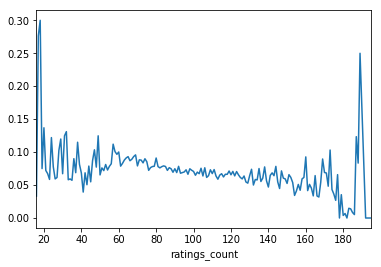

In [28]:
inspection.groupby('ratings_count').mean()['MAP'].plot()

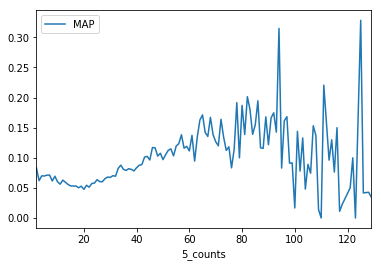

In [17]:
inspection.groupby('5_counts').mean().plot()

# Alternative version

In [18]:
def build_user_profiles(training_ratings, book_profiles):
    user_profiles = pd.DataFrame(columns=book_profiles.columns)
    user_ids = training_ratings.user_id.unique()
    list_of_5_ratings = training_ratings[training_ratings.rating==5].groupby('user_id')['book_id'].apply(list)
    for user_id in tqdm(user_ids):
        user_profiles.loc[user_id] = book_profiles.loc[list_of_5_ratings.loc[user_id]].sum()
    return pd.DataFrame(
        data = preprocessing.normalize(user_profiles.values),
        columns = user_profiles.columns,
        index = user_profiles.index
    )

user_profiles = build_user_profiles(training_ratings, book_profiles)

In [20]:
user_profiles.head()

,19th-century,20th-century,abandoned,action,action-adventure,adult,adult-fiction,adventure,africa,agatha-christie,...,PeterMatthiessen,StevePieczenik,TerriBlackstock,JohnRawls,OscarHijuelos,BenOkri,MilesCameron,IanMortimer,PeggyOrenstein,JohnKeegan
2,0.028589,0.066172,0.141562,0.000000,0.005125,0.144807,0.066242,0.115813,0.011281,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.021587,0.069988,0.055620,0.017669,0.017218,0.109091,0.082970,0.126721,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.006820,0.078175,0.205910,0.000000,0.000000,0.233628,0.083925,0.052193,0.008954,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.064613,0.122277,0.143215,0.000000,0.000000,0.171791,0.140650,0.027678,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.036461,0.032356,0.153009,0.010785,0.000000,0.198777,0.191284,0.070179,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
class AltContentBasedRecommender():
    name = "Alt Content-based RS"
    preds = {}

    def __init__(self, item_profiles):
        self.item_profiles = item_profiles

    def fit(self, training_ratings):
        user_ids = training_ratings.user_id.unique().tolist()
        sim = pd.DataFrame(
            data=cosine_similarity(user_profiles, self.item_profiles),
            index=user_profiles.index,
            columns=self.item_profiles.index
        )
        self.preds = {}
        for user_id in tqdm(user_ids):
            book_ids = np.array(
                sim.loc[user_id].sort_values(ascending=False).index)
            excluded_books = training_ratings[training_ratings.user_id == user_id].book_id.unique(
            ).tolist()
            recommendable = book_ids[~np.in1d(book_ids, excluded_books)]
            self.preds[user_id] = recommendable[:10]

    def recommendation_for_user(self, user_id):
        if user_id not in self.preds:
            return []
        return self.preds[user_id]

    def all_recommendation(self):
        return self.preds

In [24]:
alt_ctb_rec = AltContentBasedRecommender(book_profiles)
evl.evaluate(alt_ctb_rec)
evl.print_result()

Calculating recommendations:



Calculating metrics:



                       Content-based RS Alt Content-based RS
Mean Average Precision            7.18%                7.43%
Coverage                         80.10%               70.68%
Novelty Score                      6.31                 5.88
Diversity Score                    2.47                 2.47
Personalization Score              9.88                 9.85


The results are similar. But the first version of Content-based RS is much simpler to build.

In [28]:
user_profiles.shape

(52363, 6053)

In [29]:
user_profiles.reset_index().rename(columns={'index': 'user_id'}).to_feather('./feather/user_profiles')